# Tutorial 6: Mixed Precision Quantization Search with Mase and Optuna

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [2]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can load the Bert checkpoint directly from HuggingFace.

In [3]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.11/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


If you have previously ran the tutorial on Neural Architecture Search (NAS), run the following cell to import the best model obtained from the search process.

In [4]:
from pathlib import Path
import dill

lab2_out_dir = Path("/workspace/labs/lab2/outputs")
lab3_out_dir = Path("/workspace/labs/lab3/outputs")

with open(f"{lab2_out_dir}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [5]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads.

In [6]:
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_categorical` function, which triggers the chosen sampler to choose a layer type. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [7]:
from chop.tools.utils import deepsetattr
from copy import deepcopy


def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                kwargs["config"] = {
                    "data_in_width": 8,
                    "data_in_frac_width": 4,
                    "weight_width": 8,
                    "weight_frac_width": 4,
                    "bias_width": 8,
                    "bias_frac_width": 4,
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [8]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [9]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [10]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=1,
    timeout=60 * 60 * 24,
)

[I 2026-02-03 01:59:46,061] A new study created in memory with name: bert-tiny-nas-study
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  optuna_warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  optuna_warn(message)
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.304900
1000,0.306100
1500,0.306300
2000,0.325600
2500,0.307800
3000,0.360600


[I 2026-02-03 02:02:22,909] Trial 0 finished with value: 0.87464 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
[I 2026-02-03 03:17:15,577] A new study created in memory with name: tutorial6_integer_layerwise_widthfrac


=== Task 1: Integer per-layer width/frac search ===


/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.306400
1000,0.309400
1500,0.306900
2000,0.325100
2500,0.301600
3000,0.363700


[I 2026-02-03 03:20:00,237] Trial 0 finished with value: 0.86956 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 8, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_width': 16, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'integer', 'bert.encoder.layer.0.attention.self.value.data_in_width': 16, 'bert.encoder.layer.0.attention.self.value.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.value.weight_width': 16, 'bert.encoder.layer.0.attention.self.value.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.value.bias_width': 32, 'bert.encoder.layer.0.attention.self.value.b

Step,Training Loss
500,0.461500
1000,0.350100
1500,0.335600
2000,0.336600
2500,0.323800
3000,0.361800


[I 2026-02-03 03:22:55,529] Trial 1 finished with value: 0.86008 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 16, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.bias_width': 16, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 16, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.key.weight_width': 32, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.bias_width': 32, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type

Step,Training Loss
500,0.305800
1000,0.308300
1500,0.312700
2000,0.323400
2500,0.313900
3000,0.360100


[I 2026-02-03 03:25:26,137] Trial 2 finished with value: 0.87524 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'integer', 'bert.encoder.layer.1.attention.self.query.data_in_width': 8, 'bert.encoder.layer.1.attention.self.query.data_in_frac_width': 4, 'bert.encoder.layer.1.attention.self.query.weight_width': 8, 'bert.encoder.layer.1.attention.self.query.weight_frac_width': 8, 'bert.encoder.layer.1.attention.self.query.bias_width': 16, 'bert.encoder.layer.1.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.1.attention.self.key_type': 'integer', 'bert.encoder.layer.1.attention.self.key.data_in_width': 8, 'bert.encoder.layer.1.attention.

Step,Training Loss
500,0.317700
1000,0.269900
1500,0.290100
2000,0.300200
2500,0.287100
3000,0.336300


[I 2026-02-03 03:28:12,052] Trial 3 finished with value: 0.8752 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 32, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.query.bias_width': 16, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'integer', 'bert.encoder.layer.0.attention.self.value.data_in_width': 16, 'bert.encoder.layer.0.attention.self.value.data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.value.weight_width': 8, 'bert.encoder.layer.0.attention.self.value.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.value.bias_width': 16, 'bert.encoder.layer.0.attention.self.value.bi

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.654500
2500,0.540800
3000,0.468200


[I 2026-02-03 03:30:46,777] Trial 4 finished with value: 0.86704 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 32, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_width': 32, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 16, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.bias_width': 16, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type'

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2026-02-03 03:33:41,549] Trial 5 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 8, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.weight_width': 32, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.query.bias_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 8, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.weight_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.key.bias_width': 8, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_type': 'inte

Step,Training Loss
500,0.316200
1000,0.307500
1500,0.317600
2000,0.335200
2500,0.307500
3000,0.369000


[I 2026-02-03 03:36:10,413] Trial 6 finished with value: 0.87132 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 32, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.bias_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'integer', 'bert.encoder.layer.0.attention.output.dense.data_in_width': 16, 'bert.encoder.layer.0.attention.output.dense.data_in_frac_width': 4, 'bert.encoder.layer.0.attention.output.dense.weight_width': 8, 'bert.encoder.layer.0.attention.output.dense.weight_frac_width': 4, 'bert.encoder.layer.0.attention.output.

Step,Training Loss
500,0.325400
1000,0.277500
1500,0.291400
2000,0.300100
2500,0.288100
3000,0.337800


[I 2026-02-03 03:38:52,300] Trial 7 finished with value: 0.87692 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 32, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_width': 16, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_width': 32, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 32, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_width': 32, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.bias_width': 8, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type

Step,Training Loss
500,0.358600
1000,0.338500
1500,0.332800
2000,0.346700
2500,0.320300
3000,0.368500


[I 2026-02-03 03:41:45,192] Trial 8 finished with value: 0.86032 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 8, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.bias_width': 16, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 8, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.bias_width': 32, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_type': 

Step,Training Loss
500,0.316300
1000,0.292000
1500,0.289200
2000,0.295200
2500,0.288400
3000,0.338400


[I 2026-02-03 03:44:32,609] Trial 9 finished with value: 0.87436 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 16, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.query.bias_width': 32, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 16, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_width': 32, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.key.bias_width': 32, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type

Step,Training Loss
500,0.460100
1000,0.344400
1500,0.327200
2000,0.325700
2500,0.300100
3000,0.328500


[I 2026-02-03 03:47:05,550] Trial 10 finished with value: 0.8606 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 32, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.key.weight_width': 16, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.bias_width': 8, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'integer', 'bert.encoder.layer.0.attention.output.dense.data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense.weight_width': 16, 'bert.encoder.layer.0.attention.output.dense.weight_frac_width': 2, 'bert.encoder.layer.0.attention.output.dense.bias

Step,Training Loss
500,0.317300
1000,0.319400
1500,0.326800
2000,0.329000
2500,0.324100
3000,0.384100


[I 2026-02-03 03:49:38,421] Trial 11 finished with value: 0.87436 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'integer', 'bert.encoder.layer.1.attention.self.query.data_in_width': 8, 'bert.encoder.layer.1.attention.self.query.data_in_frac_width': 4, 'bert.encoder.layer.1.attention.self.query.weight_width': 32, 'bert.encoder.layer.1.attention.self.query.weight_frac_width': 8, 'bert.encoder.layer.1.attention.self.query.bias_width': 16, 'bert.encoder.layer.1.attention.self.query.bias_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_type': 'integer', 'bert.encoder.layer.1.attention.self.key.data_in_width': 8, 'bert.encoder.layer.1.attentio

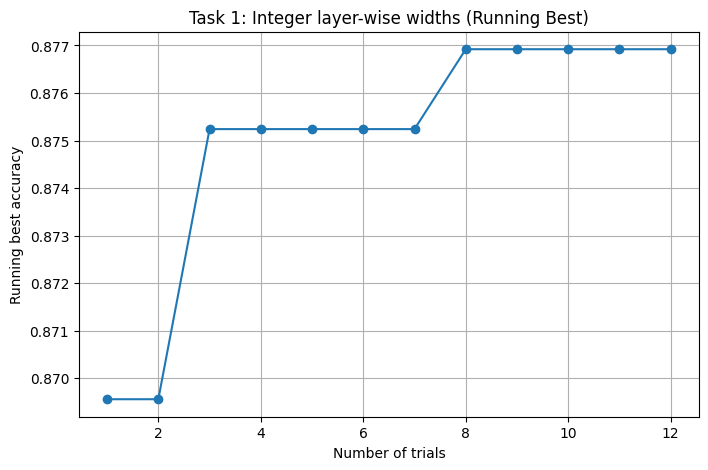

[I 2026-02-03 03:49:38,555] A new study created in memory with name: tutorial6_prec_integer


Task 1 best: 0.87692
Saved: /workspace/labs/lab3/outputs/tutorial6_task1_integer_layerwise_running_best.png

=== Task 2: Compare precision families ===

-- Running study for precision: integer


/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.307200
1000,0.309300
1500,0.306300
2000,0.324300
2500,0.298800
3000,0.362300


[I 2026-02-03 03:52:22,559] Trial 0 finished with value: 0.86916 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 8, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_width': 16, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'integer', 'bert.encoder.layer.0.attention.self.value.data_in_width': 16, 'bert.encoder.layer.0.attention.self.value.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.value.weight_width': 16, 'bert.encoder.layer.0.attention.self.value.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.value.bias_width': 32, 'bert.encoder.layer.0.attention.self.value.b

Step,Training Loss
500,0.461500
1000,0.350100
1500,0.335600
2000,0.336600
2500,0.323800
3000,0.361800


[I 2026-02-03 03:55:17,348] Trial 1 finished with value: 0.86008 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 16, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.bias_width': 16, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 16, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.key.weight_width': 32, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.bias_width': 32, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type

Step,Training Loss
500,0.310400
1000,0.311400
1500,0.311900
2000,0.323400
2500,0.310900
3000,0.360700


[I 2026-02-03 03:57:48,570] Trial 2 finished with value: 0.87512 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'integer', 'bert.encoder.layer.1.attention.self.query.data_in_width': 8, 'bert.encoder.layer.1.attention.self.query.data_in_frac_width': 4, 'bert.encoder.layer.1.attention.self.query.weight_width': 8, 'bert.encoder.layer.1.attention.self.query.weight_frac_width': 8, 'bert.encoder.layer.1.attention.self.query.bias_width': 16, 'bert.encoder.layer.1.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.1.attention.self.key_type': 'integer', 'bert.encoder.layer.1.attention.self.key.data_in_width': 8, 'bert.encoder.layer.1.attention.

Step,Training Loss
500,0.317700
1000,0.269900
1500,0.290200
2000,0.300600
2500,0.287200
3000,0.336300


[I 2026-02-03 04:00:34,724] Trial 3 finished with value: 0.87536 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 32, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.query.bias_width': 16, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'integer', 'bert.encoder.layer.0.attention.self.value.data_in_width': 16, 'bert.encoder.layer.0.attention.self.value.data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.value.weight_width': 8, 'bert.encoder.layer.0.attention.self.value.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.value.bias_width': 16, 'bert.encoder.layer.0.attention.self.value.b

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.654500
2500,0.539900
3000,0.466900


[I 2026-02-03 04:03:09,571] Trial 4 finished with value: 0.86692 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 32, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_width': 32, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 16, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.bias_width': 16, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type'

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2026-02-03 04:06:04,644] Trial 5 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 8, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.weight_width': 32, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.query.bias_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 8, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.weight_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.key.bias_width': 8, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_type': 'inte

Step,Training Loss
500,0.319500
1000,0.301300
1500,0.314800
2000,0.333000
2500,0.314000
3000,0.371200


[I 2026-02-03 04:08:33,568] Trial 6 finished with value: 0.87228 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 32, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.bias_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'integer', 'bert.encoder.layer.0.attention.output.dense.data_in_width': 16, 'bert.encoder.layer.0.attention.output.dense.data_in_frac_width': 4, 'bert.encoder.layer.0.attention.output.dense.weight_width': 8, 'bert.encoder.layer.0.attention.output.dense.weight_frac_width': 4, 'bert.encoder.layer.0.attention.output.

Step,Training Loss
500,0.325400
1000,0.277700
1500,0.290900
2000,0.299400
2500,0.287800
3000,0.337900


[I 2026-02-03 04:11:15,497] Trial 7 finished with value: 0.8768 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 32, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_width': 16, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 8, 'bert.encoder.layer.0.attention.self.query.bias_width': 32, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 32, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_width': 32, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.bias_width': 8, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type'

Step,Training Loss
500,0.358600
1000,0.338500
1500,0.332800
2000,0.346700
2500,0.320300
3000,0.368500


[I 2026-02-03 04:14:08,425] Trial 8 finished with value: 0.86032 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 8, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.bias_width': 16, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 8, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.bias_width': 32, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_type': 

Step,Training Loss
500,0.316300
1000,0.292100
1500,0.291100
2000,0.297100
2500,0.292300
3000,0.341600


[I 2026-02-03 04:16:56,316] Trial 9 finished with value: 0.87476 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'integer', 'bert.encoder.layer.0.attention.self.query.data_in_width': 16, 'bert.encoder.layer.0.attention.self.query.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.query.weight_width': 8, 'bert.encoder.layer.0.attention.self.query.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.query.bias_width': 32, 'bert.encoder.layer.0.attention.self.query.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 16, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.self.key.weight_width': 32, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.key.bias_width': 32, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type

Step,Training Loss
500,0.460100
1000,0.344400
1500,0.327200
2000,0.325700
2500,0.300100
3000,0.328500


[I 2026-02-03 04:19:28,948] Trial 10 finished with value: 0.8606 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'integer', 'bert.encoder.layer.0.attention.self.key.data_in_width': 32, 'bert.encoder.layer.0.attention.self.key.data_in_frac_width': 2, 'bert.encoder.layer.0.attention.self.key.weight_width': 16, 'bert.encoder.layer.0.attention.self.key.weight_frac_width': 4, 'bert.encoder.layer.0.attention.self.key.bias_width': 8, 'bert.encoder.layer.0.attention.self.key.bias_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_type': 'fp', 'bert.encoder.layer.0.attention.output.dense_type': 'integer', 'bert.encoder.layer.0.attention.output.dense.data_in_width': 32, 'bert.encoder.layer.0.attention.output.dense.data_in_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense.weight_width': 16, 'bert.encoder.layer.0.attention.output.dense.weight_frac_width': 2, 'bert.encoder.layer.0.attention.output.dense.bias

Step,Training Loss
500,0.407900
1000,0.307700
1500,0.308100
2000,0.300900
2500,0.287300
3000,0.311500


[I 2026-02-03 04:22:12,984] Trial 11 finished with value: 0.86636 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'fp', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'integer', 'bert.encoder.layer.0.attention.self.value.data_in_width': 32, 'bert.encoder.layer.0.attention.self.value.data_in_frac_width': 4, 'bert.encoder.layer.0.attention.self.value.weight_width': 8, 'bert.encoder.layer.0.attention.self.value.weight_frac_width': 2, 'bert.encoder.layer.0.attention.self.value.bias_width': 16, 'bert.encoder.layer.0.attention.self.value.bias_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_type': 'fp', 'bert.encoder.layer.0.intermediate.dense_type': 'integer', 'bert.encoder.layer.0.intermediate.dense.data_in_width': 16, 'bert.encoder.layer.0.intermediate.dense.data_in_frac_width': 8, 'bert.encoder.layer.0.intermediate.dense.weight_width': 32, 'bert.encoder.layer.0.intermediate.dense.weight_frac_width': 2

Best for integer: 0.8768

-- Running study for precision: minifloat_ieee


/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[W 2026-02-03 04:22:14,268] Trial 0 failed with parameters: {'bert.encoder.layer.0.attention.self.query_type': 'minifloat_ieee', 'bert.encoder.layer.0.attention.self.key_type': 'fp', 'bert.encoder.layer.0.attention.self.value_type': 'minifloat_ieee', 'bert.encoder.layer.0.attention.output.dense_type': 'minifloat_ieee', 'bert.encoder.layer.0.intermediate.dense_type': 'fp', 'bert.encoder.layer.0.output.dense_type': 'fp', 'bert.encoder.layer.1.attention.self.query_type': 'minifloat_ieee', 'bert.encoder.layer.1.attention.self.key_type': 'minifloat_ieee', 'bert.encoder.layer.1.attention.output.dense_type': 'minifloat_ieee', 'bert.encoder.layer.1.intermediate.dense_type': 'minifloat_ieee', 'bert.encoder.layer.1.output.dense_type': 'fp', 'classifier_type': 'minifloat_ieee'} because of the follow

ValueError: No trials are completed yet.

In [12]:
import gc
import json
from copy import deepcopy
from pathlib import Path

import optuna
import matplotlib.pyplot as plt
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification

from chop.tools import get_tokenized_dataset, get_trainer
from chop.tools.utils import deepsetattr
import chop.passes as passes
from chop import MaseGraph
from chop.pipelines import CompressionPipeline

from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

lab3_out_dir = Path("/workspace/labs/lab3/outputs")
lab3_out_dir.mkdir(parents=True, exist_ok=True)

lab2_out_dir = Path("/workspace/labs/lab2/outputs")

n_trials = 12
search_epochs = 1

pruning_sparsity = 0.5
post_compress_epochs = 1

HF_INPUT_NAMES = ["input_ids", "attention_mask", "labels"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def cleanup(*objs):
    for o in objs:
        try:
            del o
        except Exception:
            pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def running_best(study: optuna.Study):
    best = float("-inf")
    xs, ys = [], []
    for t in sorted(study.trials, key=lambda x: x.number):
        if t.value is None:
            continue
        best = max(best, float(t.value))
        xs.append(len(xs) + 1)
        ys.append(best)
    return xs, ys


def json_safe(obj):
    if isinstance(obj, type):
        return f"{obj.__module__}.{obj.__qualname__}"
    if isinstance(obj, dict):
        return {k: json_safe(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [json_safe(v) for v in obj]
    return obj


dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)


base_model_path = lab2_out_dir / "tutorial_5_best_model.pkl"
if base_model_path.exists():
    import dill

    with open(base_model_path, "rb") as f:
        base_model = dill.load(f)
else:
    base_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

try:
    base_model.config.problem_type = "single_label_classification"
except Exception:
    pass


INT_WIDTH_CHOICES = [8, 16, 32]
INT_FRAC_CHOICES = [2, 4, 8]


def make_integer_config_for_layer(trial: optuna.Trial, layer_name: str):
    din_w = trial.suggest_categorical(f"{layer_name}.data_in_width", INT_WIDTH_CHOICES)
    din_fw = trial.suggest_categorical(f"{layer_name}.data_in_frac_width", INT_FRAC_CHOICES)
    w_w = trial.suggest_categorical(f"{layer_name}.weight_width", INT_WIDTH_CHOICES)
    w_fw = trial.suggest_categorical(f"{layer_name}.weight_frac_width", INT_FRAC_CHOICES)
    b_w = trial.suggest_categorical(f"{layer_name}.bias_width", INT_WIDTH_CHOICES)
    b_fw = trial.suggest_categorical(f"{layer_name}.bias_frac_width", INT_FRAC_CHOICES)
    return {
        "data_in_width": din_w,
        "data_in_frac_width": din_fw,
        "weight_width": w_w,
        "weight_frac_width": w_fw,
        "bias_width": b_w,
        "bias_frac_width": b_fw,
    }


def config_for_precision(prec_name: str, trial: optuna.Trial | None, layer_name: str):
    if prec_name == "integer":
        return make_integer_config_for_layer(trial, layer_name)

    if prec_name in ("minifloat_ieee", "minifloat_denorm", "blockminifloat"):
        return {
            "data_in_exponent_width": 5,
            "data_in_mantissa_width": 3,
            "data_in_exponent_bias": 15,
            "weight_exponent_width": 5,
            "weight_mantissa_width": 3,
            "weight_exponent_bias": 15,
            "bias_exponent_width": 5,
            "bias_mantissa_width": 3,
            "bias_exponent_bias": 15,
        }

    if prec_name in ("log", "blocklog"):
        return {
            "data_in_width": 8,
            "data_in_frac_width": 4,
            "weight_width": 8,
            "weight_frac_width": 4,
            "bias_width": 8,
            "bias_frac_width": 4,
            "block_size": 32,
        }

    if prec_name in ("blockfp",):
        return {
            "data_in_width": 8,
            "data_in_frac_width": 4,
            "weight_width": 8,
            "weight_frac_width": 4,
            "bias_width": 8,
            "bias_frac_width": 4,
            "block_size": 32,
        }

    if prec_name in ("binary", "binary_scaling", "binary_residual_sign"):
        return {
            "data_in_levels": 2,
            "weight_levels": 2,
            "bias_levels": 2,
        }

    return {
        "data_in_width": 8,
        "data_in_frac_width": 4,
        "weight_width": 8,
        "weight_frac_width": 4,
        "bias_width": 8,
        "bias_frac_width": 4,
    }


PRECISIONS = [
    ("integer", LinearInteger),
    ("minifloat_ieee", LinearMinifloatIEEE),
    ("minifloat_denorm", LinearMinifloatDenorm),
    ("log", LinearLog),
    ("blockfp", LinearBlockFP),
    ("blockminifloat", LinearBlockMinifloat),
    ("blocklog", LinearBlockLog),
    ("binary", LinearBinary),
    ("binary_scaling", LinearBinaryScaling),
    ("binary_residual_sign", LinearBinaryResidualSign),
]
PREC_BY_NAME = {n: c for n, c in PRECISIONS}


def build_layer_kwargs(prec_name: str, trial: optuna.Trial | None, layer_cls, name: str, layer: nn.Linear):
    kwargs = {
        "in_features": layer.in_features,
        "out_features": layer.out_features,
    }

    try:
        import inspect

        params = inspect.signature(layer_cls.__init__).parameters
    except Exception:
        params = {}

    if "bias" in params:
        kwargs["bias"] = (layer.bias is not None)

    if "config" in params:
        cfg = config_for_precision(prec_name, trial, name)
        kwargs["config"] = cfg

    if layer_cls is LinearInteger and "config" not in params and trial is not None:
        cfg = make_integer_config_for_layer(trial, name)
        for k, v in cfg.items():
            if k in params:
                kwargs[k] = v

    return kwargs


def construct_model_for_precision(trial: optuna.Trial, prec_name: str):
    prec_cls = PREC_BY_NAME[prec_name]
    trial_model = deepcopy(base_model)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear):
            choice = trial.suggest_categorical(f"{name}_type", ("fp", prec_name))
            if choice == "fp":
                continue

            kwargs = build_layer_kwargs(prec_name, trial, prec_cls, name, layer)
            new_layer = prec_cls(**kwargs)

            with torch.no_grad():
                try:
                    if hasattr(new_layer, "weight") and hasattr(layer, "weight") and new_layer.weight.shape == layer.weight.shape:
                        new_layer.weight.copy_(layer.weight)
                except Exception:
                    pass
                try:
                    if layer.bias is not None and hasattr(new_layer, "bias") and new_layer.bias is not None:
                        if getattr(new_layer.bias, "shape", None) == layer.bias.shape:
                            new_layer.bias.copy_(layer.bias)
                except Exception:
                    pass

            deepsetattr(trial_model, name, new_layer)

    try:
        trial_model.config.problem_type = "single_label_classification"
    except Exception:
        pass

    return trial_model


def make_objective_for_precision(prec_name: str):
    def objective(trial: optuna.Trial):
        trainer = None
        model = None
        try:
            model = construct_model_for_precision(trial, prec_name).to(device)
            trainer = get_trainer(
                model=model,
                tokenized_dataset=dataset,
                tokenizer=tokenizer,
                evaluate_metric="accuracy",
                num_train_epochs=search_epochs,
            )
            trainer.train()
            ev = trainer.evaluate()
            return float(ev["eval_accuracy"])
        finally:
            cleanup(trainer, model)

    return objective


print("=== Task 1: Integer per-layer width/frac search ===")
sampler = optuna.samplers.TPESampler(seed=0)
study_int = optuna.create_study(direction="maximize", sampler=sampler, study_name="tutorial6_integer_layerwise_widthfrac")
study_int.optimize(make_objective_for_precision("integer"), n_trials=n_trials)

x1, y1 = running_best(study_int)
plt.figure(figsize=(8, 5))
plt.plot(x1, y1, marker="o")
plt.xlabel("Number of trials")
plt.ylabel("Running best accuracy")
plt.title("Task 1: Integer layer-wise widths (Running Best)")
plt.grid(True)
task1_plot = lab3_out_dir / "tutorial6_task1_integer_layerwise_running_best.png"
plt.savefig(task1_plot)
plt.show()

print("Task 1 best:", float(study_int.best_value))
print("Saved:", task1_plot)


print("\n=== Task 2: Compare precision families ===")
studies = {}
for prec_name, _ in PRECISIONS:
    print(f"\n-- Running study for precision: {prec_name}")
    sampler = optuna.samplers.TPESampler(seed=0)
    st = optuna.create_study(direction="maximize", sampler=sampler, study_name=f"tutorial6_prec_{prec_name}")
    st.optimize(make_objective_for_precision(prec_name), n_trials=n_trials, catch=(KeyError, AssertionError, RuntimeError, TypeError))
    studies[prec_name] = st
    if st.best_trial is not None and st.best_value is not None:
        print(f"Best for {prec_name}: {float(st.best_value):.4f}")
    else:
        print(f"Best for {prec_name}: None (all trials failed)")


plt.figure(figsize=(10, 6))
for prec_name, st in studies.items():
    xs, ys = running_best(st)
    if xs:
        plt.plot(xs, ys, label=prec_name)
plt.xlabel("Number of trials")
plt.ylabel("Running best accuracy")
plt.title("Task 2: Running Best Accuracy per Precision")
plt.grid(True)
plt.legend()
task2_plot = lab3_out_dir / "tutorial6_task2_all_precisions_running_best.png"
plt.savefig(task2_plot)
plt.show()

print("Saved:", task2_plot)


summary = {
    "task1_integer_layerwise": {
        "best_value": float(study_int.best_value),
        "best_params": json_safe(study_int.best_params),
        "n_trials": len(study_int.trials),
        "search_epochs": search_epochs,
        "sampler": "TPESampler",
        "plot": str(task1_plot),
    },
    "task2_all_precisions": {
        "n_trials_each": n_trials,
        "search_epochs": search_epochs,
        "sampler": "TPESampler",
        "plot": str(task2_plot),
        "best_by_precision": {
            name: {
                "best_value": (float(st.best_value) if st.best_trial is not None and st.best_value is not None else None),
                "best_params": (json_safe(st.best_params) if st.best_trial is not None and st.best_value is not None else None),
            }
            for name, st in studies.items()
        },
    },
}
summary_path = lab3_out_dir / "tutorial6_impl_tasks_summary.json"
with summary_path.open("w") as f:
    json.dump(summary, f, indent=2)
print("Saved summary JSON:", summary_path)


BASE_QUANTIZATION_CONFIG = {
    "by": "type",
    "default": {"config": {"name": None}},
    "linear": {
        "config": {
            "name": "integer",
            "data_in_width": 8,
            "data_in_frac_width": 4,
            "weight_width": 8,
            "weight_frac_width": 4,
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}
BASE_PRUNING_CONFIG = {
    "weight": {"sparsity": pruning_sparsity, "method": "l1-norm", "scope": "local"},
    "activation": {"sparsity": pruning_sparsity, "method": "l1-norm", "scope": "local"},
}


def compress_with_mase(model_cpu: nn.Module):
    mg = MaseGraph(model_cpu, hf_input_names=HF_INPUT_NAMES)
    mg, _ = passes.init_metadata_analysis_pass(mg)
    mg, _ = passes.add_common_metadata_analysis_pass(mg)

    qcfg = deepcopy(BASE_QUANTIZATION_CONFIG)
    pcfg = deepcopy(BASE_PRUNING_CONFIG)

    pipe = CompressionPipeline()
    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": qcfg,
            "prune_transform_pass": pcfg,
        },
    )
    return mg


print("\n=== Optional: Compression on Task 1 best model ===")
fixed_trial = optuna.trial.FixedTrial(study_int.best_params)
best_model_task1 = construct_model_for_precision(fixed_trial, "integer")

mg_a = None
trainer_a = None
try:
    mg_a = compress_with_mase(deepcopy(best_model_task1).to("cpu"))
    model_a = mg_a.model.to(device)
    trainer_a = get_trainer(
        model=model_a,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=0,
    )
    ev_a = trainer_a.evaluate()
    acc_a = float(ev_a["eval_accuracy"])
    print(f"Compressed (no post-train) eval_accuracy: {acc_a:.4f}")
finally:
    cleanup(trainer_a, mg_a)


mg_b = None
trainer_b = None
try:
    mg_b = compress_with_mase(deepcopy(best_model_task1).to("cpu"))
    model_b = mg_b.model.to(device)
    trainer_b = get_trainer(
        model=model_b,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=post_compress_epochs,
    )
    trainer_b.train()
    ev_b = trainer_b.evaluate()
    acc_b = float(ev_b["eval_accuracy"])
    print(f"Compressed (+ post-train {post_compress_epochs} epoch) eval_accuracy: {acc_b:.4f}")
finally:
    cleanup(trainer_b, mg_b)

print("\nDone.")